In [ ]:
#!pip install ucimlrepo



In [10]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
challenger_usa_space_shuttle_o_ring = fetch_ucirepo(id=92) 


In [39]:
import torch
import pandas as pd
import numpy as np

In [15]:
# convert to torch tensor
X = torch.tensor(challenger_usa_space_shuttle_o_ring.data.features['launch_temp'].values, dtype=torch.int64)
y = torch.tensor(challenger_usa_space_shuttle_o_ring.data.features['num_thermal_distress'].values, dtype=torch.int64)
print(X)
print(y)

tensor([66, 70, 69, 68, 67, 72, 73, 70, 57, 63, 70, 78, 67, 53, 67, 75, 70, 81,
        76, 79, 75, 76, 58])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1])


In [24]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import pyro.optim

num_classes = 3

# Model: Multinomial logistic regression (softmax regression)
def model(X, y):
    # beta0, beta1: shape (num_classes,)
    beta0 = pyro.sample("beta0", dist.Normal(torch.zeros(num_classes), 10.0 * torch.ones(num_classes)).to_event(1))
    beta1 = pyro.sample("beta1", dist.Normal(torch.zeros(num_classes), 10.0 * torch.ones(num_classes)).to_event(1))
    # Compute logits for each data point and class
    logits = beta0.unsqueeze(0) + beta1.unsqueeze(0) * X.unsqueeze(1).float()  # shape (N, num_classes)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

# Guide: Mean-field variational family
def guide(X, y):
    beta0_loc = pyro.param("beta0_loc", torch.zeros(num_classes))
    beta0_scale = pyro.param("beta0_scale", torch.ones(num_classes), constraint=dist.constraints.positive)
    beta1_loc = pyro.param("beta1_loc", torch.zeros(num_classes))
    beta1_scale = pyro.param("beta1_scale", torch.ones(num_classes), constraint=dist.constraints.positive)
    pyro.sample("beta0", dist.Normal(beta0_loc, beta0_scale).to_event(1))
    pyro.sample("beta1", dist.Normal(beta1_loc, beta1_scale).to_event(1))

# Example usage:
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_steps = 5000
for step in range(num_steps):
    loss = svi.step(X, y)
    if step % 500 == 0:
        print(f"Step {step} : loss = {loss}")

# Posterior means
print("beta0 mean:", pyro.param("beta0_loc").detach().numpy())
print("beta1 mean:", pyro.param("beta1_loc").detach().numpy())

Step 0 : loss = 839.6551880836487
Step 500 : loss = 86.36333334445953
Step 1000 : loss = 42.37252163887024
Step 1500 : loss = 110.3492751121521
Step 2000 : loss = 91.56417465209961
Step 2500 : loss = 47.166054248809814
Step 3000 : loss = 64.00536775588989
Step 3500 : loss = 58.12256622314453
Step 4000 : loss = 42.921379804611206
Step 4500 : loss = 46.54620361328125
beta0 mean: [-2.7108188  2.3766716  1.222804 ]
beta1 mean: [ 0.12986013  0.03061332 -0.00103413]


In [48]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import pyro.optim

n_trials = 6  # Each launch has 6 O-rings

# Model: Binomial regression
def model(X, y, n_trials):
    beta0 = pyro.sample("beta0", dist.Normal(0., 1.))
    beta1 = pyro.sample("beta1", dist.Normal(0., 1.))
    logits = beta0 + beta1 * X
    probs = torch.sigmoid(logits)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Binomial(total_count=n_trials, probs=probs), obs=y)

# Guide: Mean-field variational family
def guide(X, y, n_trials):
    beta0_loc = pyro.param("beta0_loc", torch.tensor(0.))
    beta0_scale = pyro.param("beta0_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    beta1_loc = pyro.param("beta1_loc", torch.tensor(0.))
    beta1_scale = pyro.param("beta1_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    pyro.sample("beta0", dist.Normal(beta0_loc, beta0_scale))
    pyro.sample("beta1", dist.Normal(beta1_loc, beta1_scale))

# Inference
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.001})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_steps = 50000
for step in range(num_steps):
    loss = svi.step(X, y, n_trials)
    if step % 5000 == 0:
        print(f"Step {step} : loss = {loss}")

# Posterior means
print("beta0 mean:", pyro.param("beta0_loc").item())
print("beta1 mean:", pyro.param("beta1_loc").item())


Step 0 : loss = 76.4981460571289
Step 5000 : loss = 130.53910940885544
Step 10000 : loss = 130.6483433842659
Step 15000 : loss = 130.59316897392273
Step 20000 : loss = 129.58850520849228
Step 25000 : loss = 130.64499509334564
Step 30000 : loss = 130.29872673749924
Step 35000 : loss = 130.78859508037567
Step 40000 : loss = 130.82708859443665
Step 45000 : loss = 130.2128911614418
beta0 mean: 0.048764754086732864
beta1 mean: -0.6322280764579773


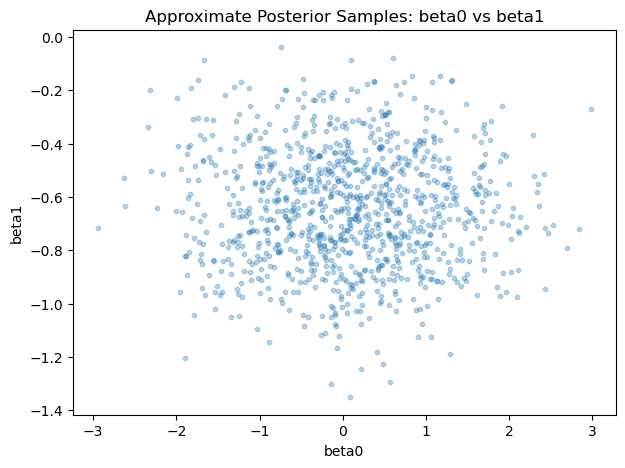

In [49]:
import matplotlib.pyplot as plt

# Get variational parameters
beta0_loc = pyro.param("beta0_loc").item()
beta0_scale = pyro.param("beta0_scale").item()
beta1_loc = pyro.param("beta1_loc").item()
beta1_scale = pyro.param("beta1_scale").item()

# Sample from the variational posterior
n_samples = 1000
beta0_samples = torch.normal(beta0_loc, beta0_scale, size=(n_samples,))
beta1_samples = torch.normal(beta1_loc, beta1_scale, size=(n_samples,))

plt.figure(figsize=(7, 5))
plt.scatter(beta0_samples, beta1_samples, alpha=0.3, s=10)
plt.xlabel("beta0")
plt.ylabel("beta1")
plt.title("Approximate Posterior Samples: beta0 vs beta1")
plt.show()

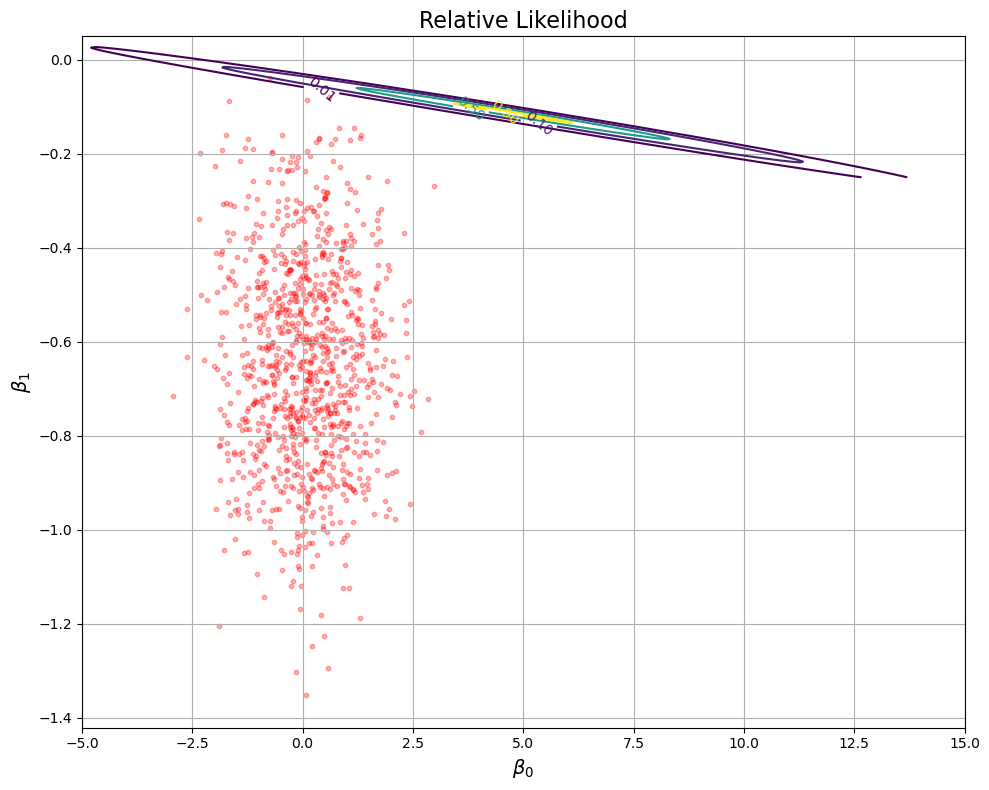

In [53]:
# Define log-likelihood function
temp = X.numpy()
failure = y.numpy()

def loglik(beta):
    linear = beta[0] + beta[1] * temp
    return np.sum(failure * linear) - np.sum(7 * np.log(1 + np.exp(linear)))

# Grid for beta0 and beta1
beta0 = np.linspace(-5, 15, 200)
beta1 = np.linspace(-0.25, 0.05, 200)
B0, B1 = np.meshgrid(beta0, beta1)
grid = np.stack([B0.ravel(), B1.ravel()], axis=-1)

# Evaluate log-likelihood on the grid
l_vals = np.array([loglik(b) for b in grid])
l_vals = l_vals.reshape(len(beta1), len(beta0))
rel_lik = np.exp(l_vals - np.max(l_vals))

# Contour plot
plt.figure(figsize=(10, 8))
cs = plt.contour(beta0, beta1, rel_lik, levels=[0.01, 0.1, 0.5, 0.9], cmap="viridis")
plt.scatter(beta0_samples.numpy(), beta1_samples.numpy(), alpha=0.3, s=10, color='red', label='Posterior samples')

plt.clabel(cs, inline=True, fontsize=10)
plt.xlabel(r"$\beta_0$", fontsize=14)
plt.ylabel(r"$\beta_1$", fontsize=14)
plt.title("Relative Likelihood", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()